Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [X] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [X] Do exploratory visualizations with Seaborn.
- [X] Do one-hot encoding of categorical features.
- [X] Do feature selection with `SelectKBest`.
- [X] Fit a linear regression model with multiple features.
- [X] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [X] Try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) instead of Linear Regression, especially if your errors blow up! Watch [Aaron Gallant's 9 minute video on Ridge Regression](https://www.youtube.com/watch?v=XK5jkedy17w) to learn more.
- [X] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [0]:
import os, sys
in_colab = 'google.colab' in sys.modules

# If you're in Colab...
if in_colab:
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Install required python packages
    !pip install -r requirements.txt
    
    # Change into directory for module
    os.chdir('module3')

Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 104, done.
remote: Total 104 (delta 0), reused 0 (delta 0), pack-reused 104
Receiving objects: 100% (104/104), 17.31 MiB | 19.33 MiB/s, done.
Resolving deltas: 100% (41/41), done.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/master
     |████████████████████████████████| 92kB 3.5MB/s 
     |████████████████████████████████| 112kB 11.4MB/s 
     |████████████████████████████████| 133kB 48.6MB/s 
     |████████████████████████████████| 57.7MB 512kB/s 
     |████████████████████████████████| 235kB 44.3MB/s 
     |████████████████████████████████| 614kB 39.8MB/s 
     |████████████████████████████████| 225kB 46.8MB/s 
     |████████████████████████████████| 768kB 47.6MB/s 
     |████████████████████████████████| 194kB 48.5MB/s 
     |████████████████████████████████| 51kB 22.6MB/s 
     |█████████

In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

## Use a subset of the data

Predict **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

In [0]:
mask = ((df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS') &
        (df['SALE_PRICE'] > 100000) & 
        (df['SALE_PRICE'] < 2000000))

df = df[mask]

## Do train/test split

Use data from January — March 2019 to train. Use data from April 2019 to test.

In [0]:
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)
df['SALE_DATE'].describe()

count                    3151
unique                     91
top       2019-01-31 00:00:00
freq                       78
first     2019-01-01 00:00:00
last      2019-04-30 00:00:00
Name: SALE_DATE, dtype: object

In [0]:
cutoff = pd.to_datetime('2019-04-01')
train = df[df.SALE_DATE < cutoff]
test  = df[df.SALE_DATE >= cutoff]
train.shape, test.shape

((2507, 21), (644, 21))

In [0]:
import pandas_profiling
train.profile_report()

## Do exploratory visualizations with Seaborn

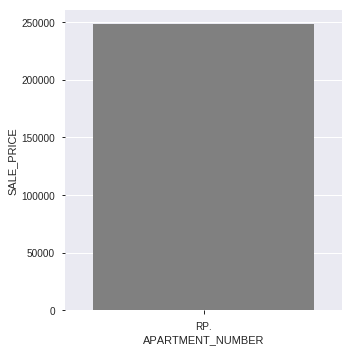

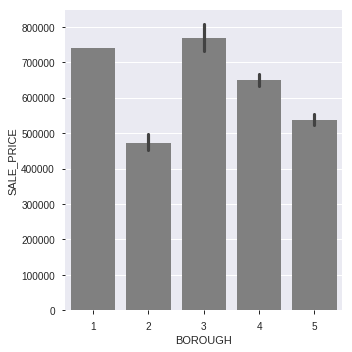

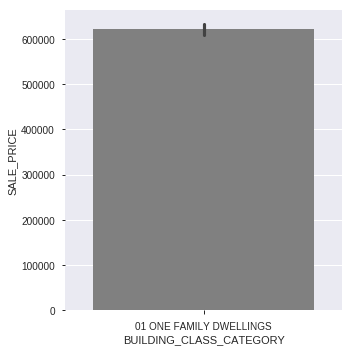

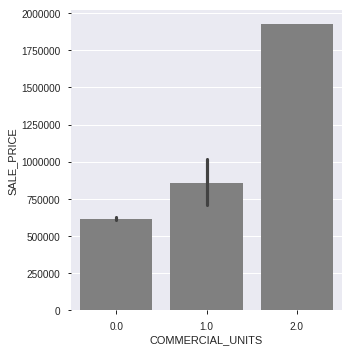

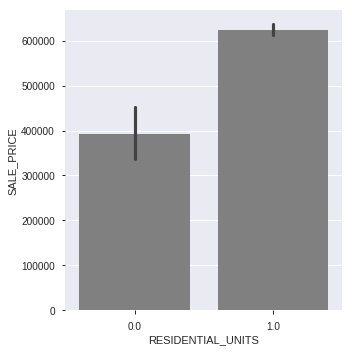

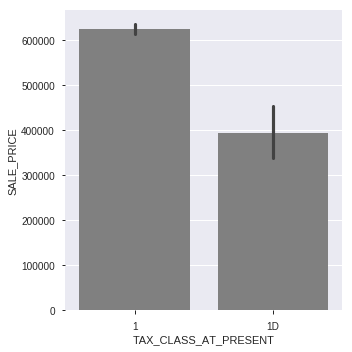

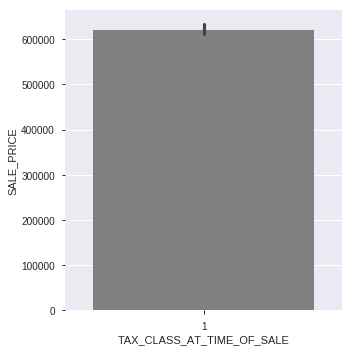

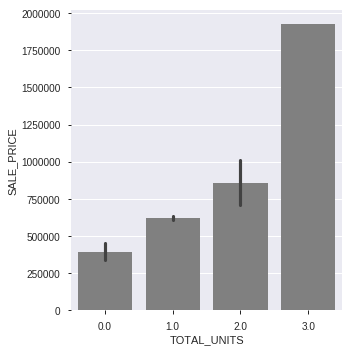

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

for col in sorted(train.columns):
    if train[col].nunique() < 10:
        try:
            sns.catplot(x=col, y='SALE_PRICE', data=train, kind='bar', color='grey')
            plt.show()
        except:
            pass

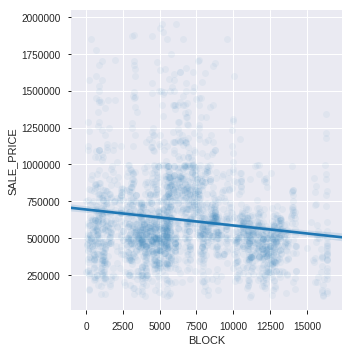

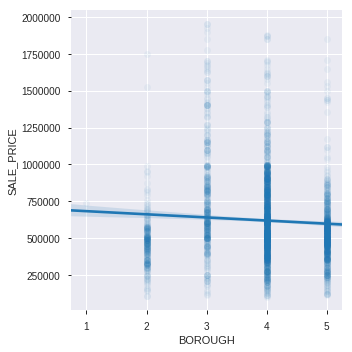

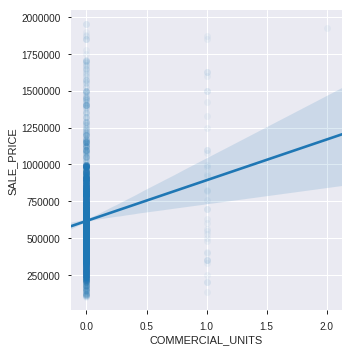

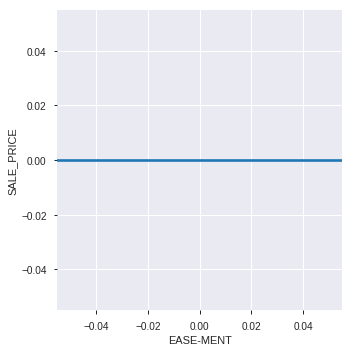

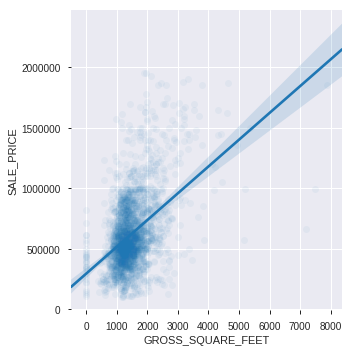

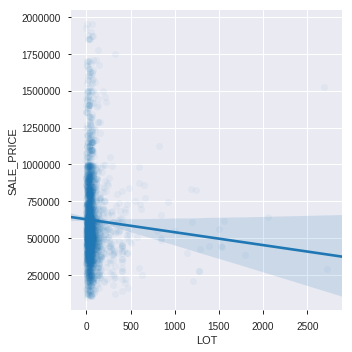

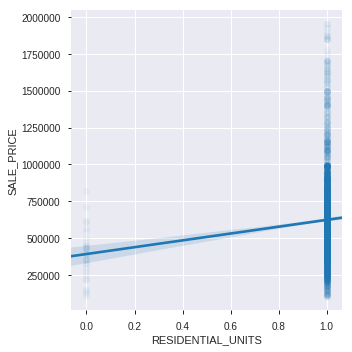

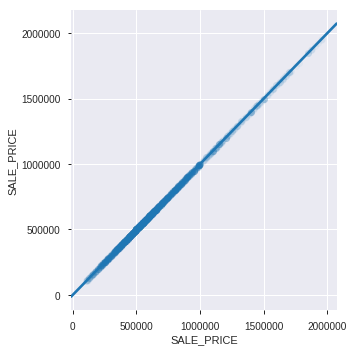

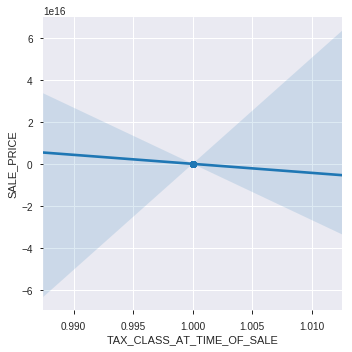

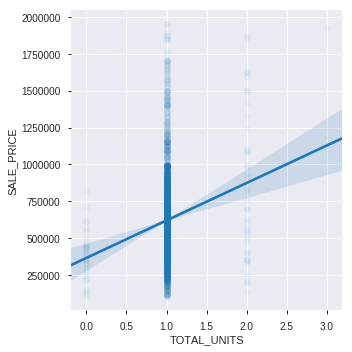

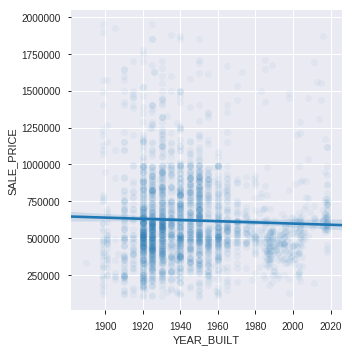

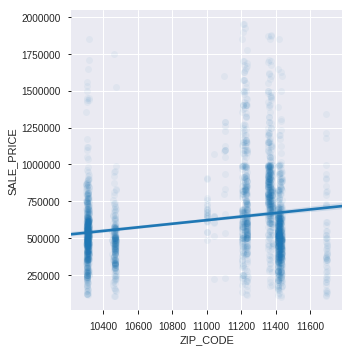

In [0]:
numeric = train.select_dtypes('number')
for col in sorted(numeric.columns):
    sns.lmplot(x=col, y='SALE_PRICE', data=train, scatter_kws=dict(alpha=0.05))
    plt.show()

In [0]:
train.BOROUGH.info()

NameError: ignored

## Do one-hot encoding of categorical features

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
train['BOROUGH'] = train['BOROUGH'].astype(str)
test['BOROUGH'] = test['BOROUGH'].astype(str)

In [0]:
# Check cardinality of non-numeric features
train.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq,first,last
BUILDING_CLASS_CATEGORY,2507,1,01 ONE FAMILY DWELLINGS,2507,NaN,NaN
APARTMENT_NUMBER,1,1,RP.,1,NaN,NaN
TAX_CLASS_AT_PRESENT,2507,2,1,2476,NaN,NaN
BOROUGH,2507,5,4,1204,NaN,NaN
BUILDING_CLASS_AT_TIME_OF_SALE,2507,11,A1,919,NaN,NaN
BUILDING_CLASS_AT_PRESENT,2507,13,A1,919,NaN,NaN
SALE_DATE,2507,68,2019-01-31 00:00:00,78,2019-01-01 00:00:00,2019-03-30 00:00:00
NEIGHBORHOOD,2507,176,FLUSHING-NORTH,77,NaN,NaN
LAND_SQUARE_FEET,2507,887,"4,000",234,NaN,NaN
ADDRESS,2507,2497,294 FREEBORN STREET,2,NaN,NaN


In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

train['NEIGHBORHOOD'].value_counts()

OTHER                       1908
FLUSHING-NORTH                77
GREAT KILLS                   69
ST. ALBANS                    66
SPRINGFIELD GARDENS           66
QUEENS VILLAGE                64
SO. JAMAICA-BAISLEY PARK      64
SOUTH OZONE PARK              49
BAYSIDE                       48
MIDLAND BEACH                 48
LAURELTON                     48
Name: NEIGHBORHOOD, dtype: int64

In [0]:
target = 'SALE_PRICE'
numerics = train.select_dtypes(include='number').columns.drop(target).tolist()
categoricals = train.select_dtypes(exclude='number').columns.tolist()
low_cardinality_categoricals = [col for col in categoricals
                               if train[col].nunique() <= 50]

features = numerics + low_cardinality_categoricals


X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [0]:
import category_encoders as ce

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

X_train_encoded.head()

,BLOCK,LOT,EASE-MENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_QUEENS VILLAGE,NEIGHBORHOOD_BAYSIDE,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_LAURELTON,NEIGHBORHOOD_SO. JAMAICA-BAISLEY PARK,NEIGHBORHOOD_SPRINGFIELD GARDENS,NEIGHBORHOOD_GREAT KILLS,NEIGHBORHOOD_SOUTH OZONE PARK,NEIGHBORHOOD_MIDLAND BEACH,NEIGHBORHOOD_ST. ALBANS,BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A3,BUILDING_CLASS_AT_PRESENT_S1,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_A6,BUILDING_CLASS_AT_PRESENT_A8,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_S0,BUILDING_CLASS_AT_PRESENT_B3,APARTMENT_NUMBER_nan,APARTMENT_NUMBER_RP.,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0
44,5495,801,NaN,11230.0,1.0,0.0,1.0,1325.0,1930.0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
61,7918,72,NaN,11427.0,1.0,0.0,1.0,2001.0,1940.0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
78,4210,19,NaN,10461.0,1.0,0.0,1.0,2043.0,1925.0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
108,5212,69,NaN,11226.0,1.0,0.0,1.0,2680.0,1899.0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
111,7930,121,NaN,11203.0,1.0,0.0,1.0,1872.0,1940.0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0


## Fit a linear regression model with multiple features. Get mean absolute error for the test set.

In [0]:
# Drop EASE-MENT, it's null 100% of the time
X_train_encoded = X_train_encoded.drop(columns='EASE-MENT')
X_test_encoded = X_test_encoded.drop(columns='EASE-MENT')

In [0]:
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

for k in range(1, len(X_train_encoded.columns)+1):
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)
    
    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    
    y_pred = model.predict(X_test_selected)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Test MAE: ${mae:,.0f} \n')

1 features
Test MAE: $183,641 

2 features
Test MAE: $182,569 

3 features
Test MAE: $182,569 

4 features
Test MAE: $183,441 

5 features
Test MAE: $186,532 

6 features
Test MAE: $182,366 

7 features
Test MAE: $194,204 

8 features
Test MAE: $172,203 

9 features
Test MAE: $171,721 

10 features
Test MAE: $162,840 

11 features
Test MAE: $163,984 

12 features
Test MAE: $162,140 

13 features
Test MAE: $161,428 

14 features
Test MAE: $161,430 

15 features
Test MAE: $161,301 

16 features
Test MAE: $163,095 

17 features
Test MAE: $162,964 

18 features
Test MAE: $162,964 

19 features
Test MAE: $162,752 

20 features
Test MAE: $162,752 

21 features
Test MAE: $162,560 

22 features
Test MAE: $163,008 

23 features
Test MAE: $163,057 

24 features
Test MAE: $163,057 

25 features
Test MAE: $163,057 

26 features
Test MAE: $162,779 

27 features
Test MAE: $20,955,941,571,174,472 

28 features
Test MAE: $162,722 

29 features
Test MAE: $27,788,224,381,348 

30 features
Test MAE: $6,7

## Try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) instead of Linear Regression, especially if your errors blow up

In [0]:
from sklearn.linear_model import RidgeCV

for k in range(1, len(X_train_encoded.columns)+1):
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)
    
    model = RidgeCV()
    model.fit(X_train_selected, y_train)
    
    y_pred = model.predict(X_test_selected)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Test MAE: ${mae:,.0f} \n')

1 features
Test MAE: $183,670 

2 features
Test MAE: $182,607 

3 features
Test MAE: $182,605 

4 features
Test MAE: $183,452 

5 features
Test MAE: $181,936 

6 features
Test MAE: $182,395 

7 features
Test MAE: $175,540 

8 features
Test MAE: $172,216 

9 features
Test MAE: $171,783 

10 features
Test MAE: $162,833 

11 features
Test MAE: $163,934 

12 features
Test MAE: $162,200 

13 features
Test MAE: $161,373 

14 features
Test MAE: $161,375 

15 features
Test MAE: $161,070 

16 features
Test MAE: $163,054 

17 features
Test MAE: $162,922 

18 features
Test MAE: $162,922 

19 features
Test MAE: $162,709 

20 features
Test MAE: $162,709 

21 features
Test MAE: $162,516 

22 features
Test MAE: $162,964 

23 features
Test MAE: $162,814 

24 features
Test MAE: $162,836 

25 features
Test MAE: $162,837 

26 features
Test MAE: $162,748 

27 features
Test MAE: $162,707 

28 features
Test MAE: $162,691 

29 features
Test MAE: $162,767 

30 features
Test MAE: $162,746 

31 features
Test MA

In [0]:
# Which features were used?
k = 15
selector = SelectKBest(score_func=f_regression, k=k)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)

all_names = X_train_encoded.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)

print('\nFeatures not selected:')
for name in unselected_names:
    print(name)

Features selected:
BLOCK
ZIP_CODE
COMMERCIAL_UNITS
TOTAL_UNITS
GROSS_SQUARE_FEET
BOROUGH_3
BOROUGH_2
BOROUGH_5
NEIGHBORHOOD_OTHER
NEIGHBORHOOD_BAYSIDE
NEIGHBORHOOD_FLUSHING-NORTH
BUILDING_CLASS_AT_PRESENT_A5
BUILDING_CLASS_AT_PRESENT_A3
BUILDING_CLASS_AT_TIME_OF_SALE_A5
BUILDING_CLASS_AT_TIME_OF_SALE_A3

Features not selected:
LOT
RESIDENTIAL_UNITS
YEAR_BUILT
TAX_CLASS_AT_TIME_OF_SALE
BOROUGH_4
BOROUGH_1
NEIGHBORHOOD_QUEENS VILLAGE
NEIGHBORHOOD_LAURELTON
NEIGHBORHOOD_SO. JAMAICA-BAISLEY PARK
NEIGHBORHOOD_SPRINGFIELD GARDENS
NEIGHBORHOOD_GREAT KILLS
NEIGHBORHOOD_SOUTH OZONE PARK
NEIGHBORHOOD_MIDLAND BEACH
NEIGHBORHOOD_ST. ALBANS
BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS
TAX_CLASS_AT_PRESENT_1
TAX_CLASS_AT_PRESENT_1D
BUILDING_CLASS_AT_PRESENT_A9
BUILDING_CLASS_AT_PRESENT_A1
BUILDING_CLASS_AT_PRESENT_A0
BUILDING_CLASS_AT_PRESENT_A2
BUILDING_CLASS_AT_PRESENT_S1
BUILDING_CLASS_AT_PRESENT_A4
BUILDING_CLASS_AT_PRESENT_A6
BUILDING_CLASS_AT_PRESENT_A8
BUILDING_CLASS_AT_PRESENT_B2
BUILDING